# Explore here

In [1]:
#Importamos Librerias Necesarias
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score

# EDA

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/raw/diabetes.csv')

# Visualizamos los datos
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Visualizamos las Estadísticas descriptivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
# Visualizamos la informacion de la dfsets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Verificamos si existen datos únicos
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [6]:
# Revisamos que no tengamos datos duplicados
df.duplicated().sum()

np.int64(0)

In [7]:
# Verificamos los datos nulos o faltantes
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: >

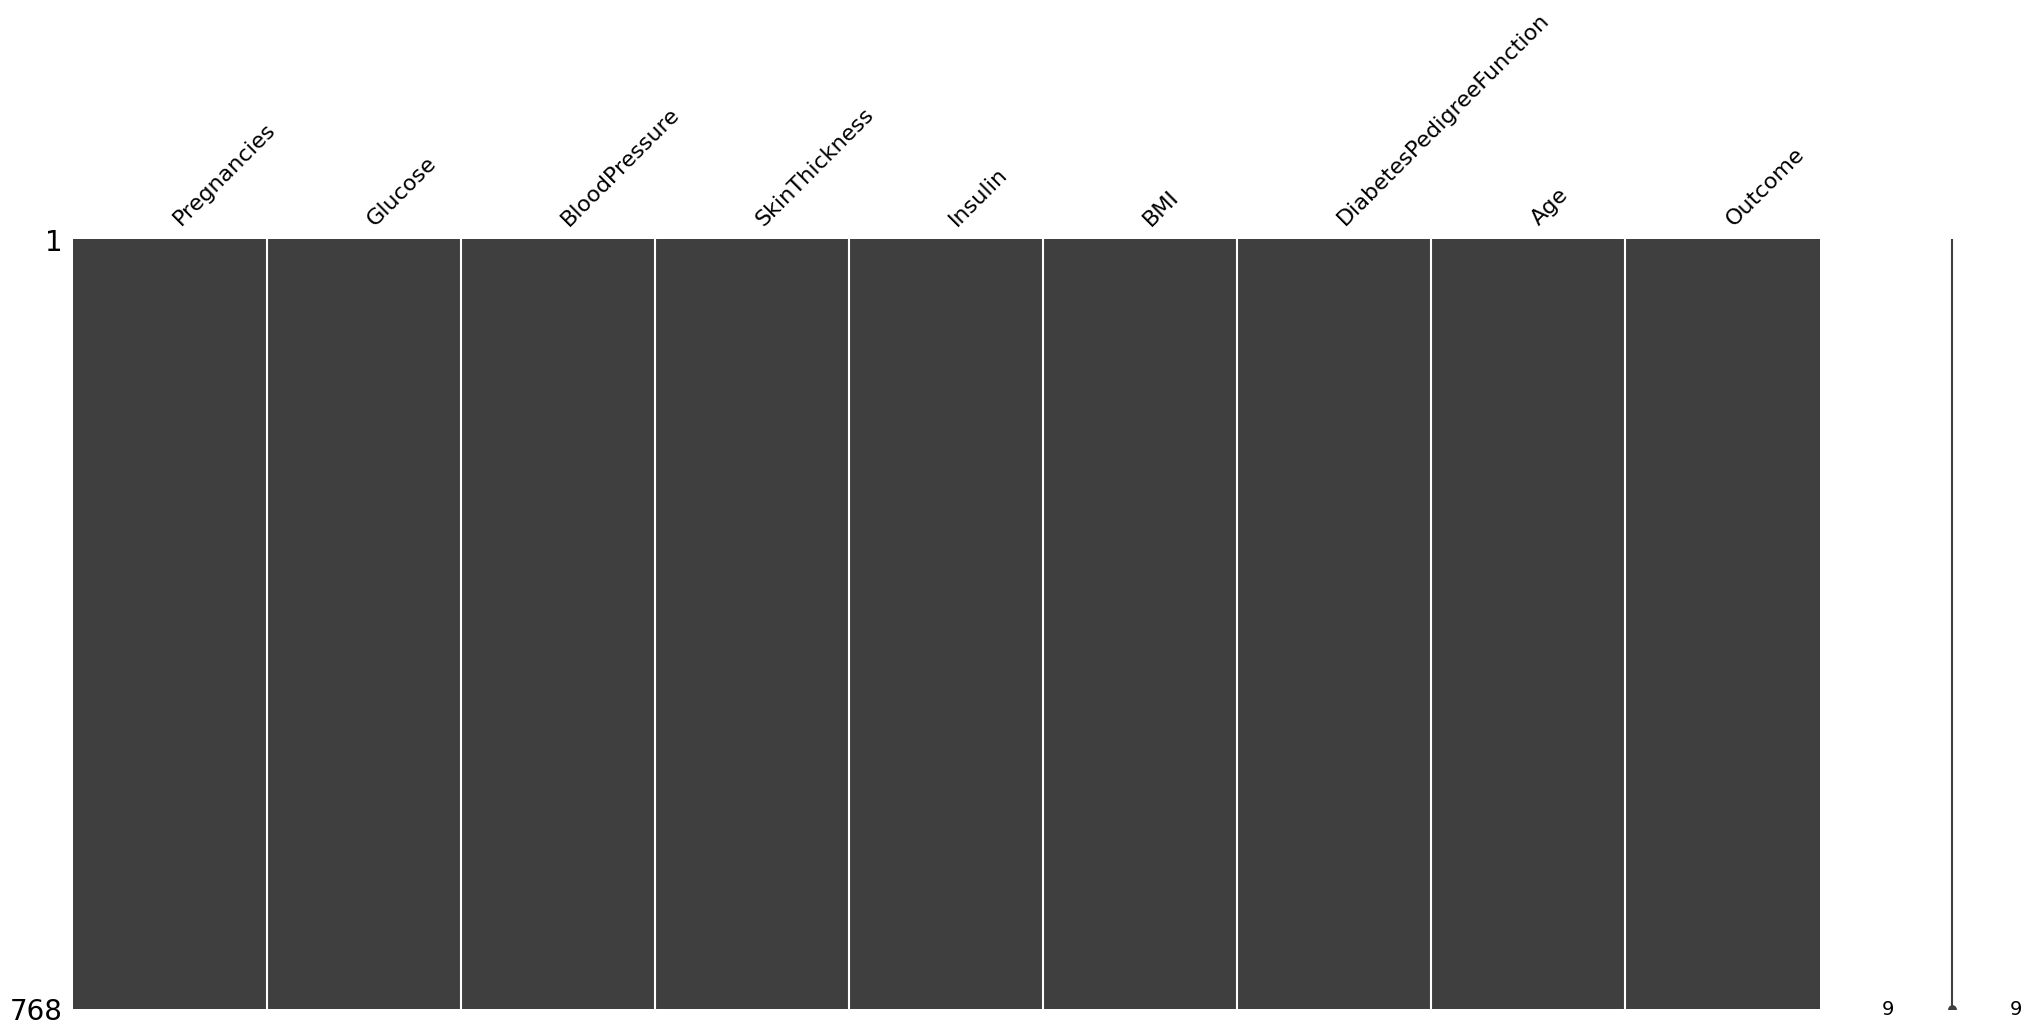

In [8]:
msno.matrix(df)

# Visualizacion

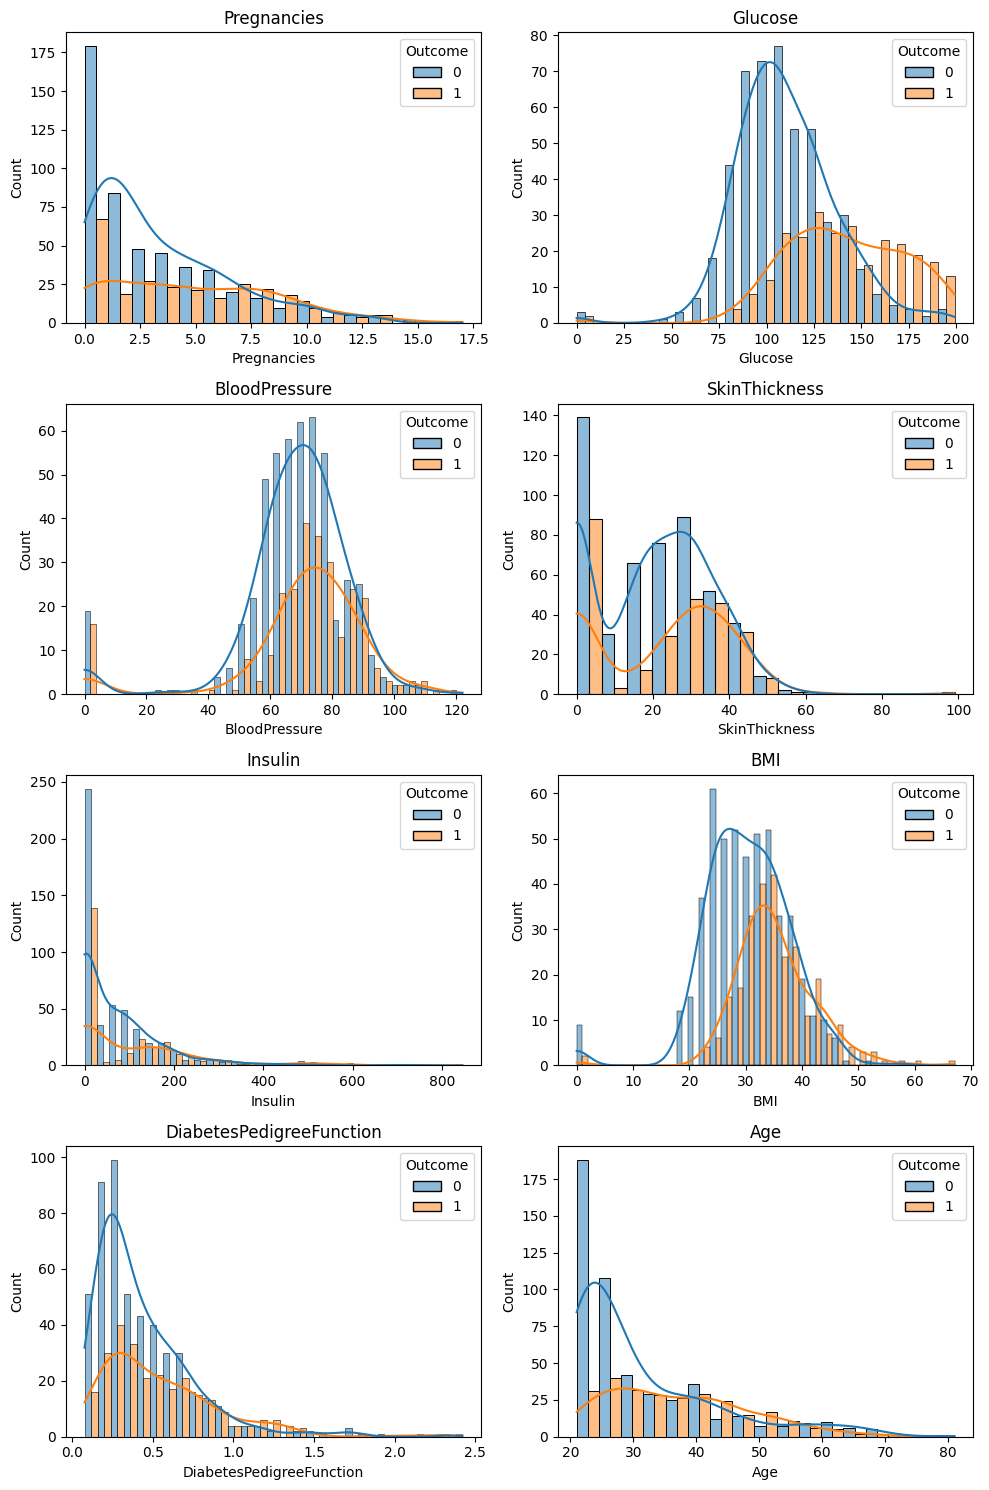

In [9]:
# Seleccinamos las columnas a graficar
columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos hisplot para cada una
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()  # Convertimos los ejes en una lista plana para iterar

# Iteramos por cada columna del dataframe
for i, columna in enumerate(columnas):
    sns.histplot(ax=axes[i], x=columna, data=df, hue='Outcome', kde=True, multiple='dodge')  
    axes[i].set_title(columna)

# Para mostrar el gráfico
plt.tight_layout()
plt.show()

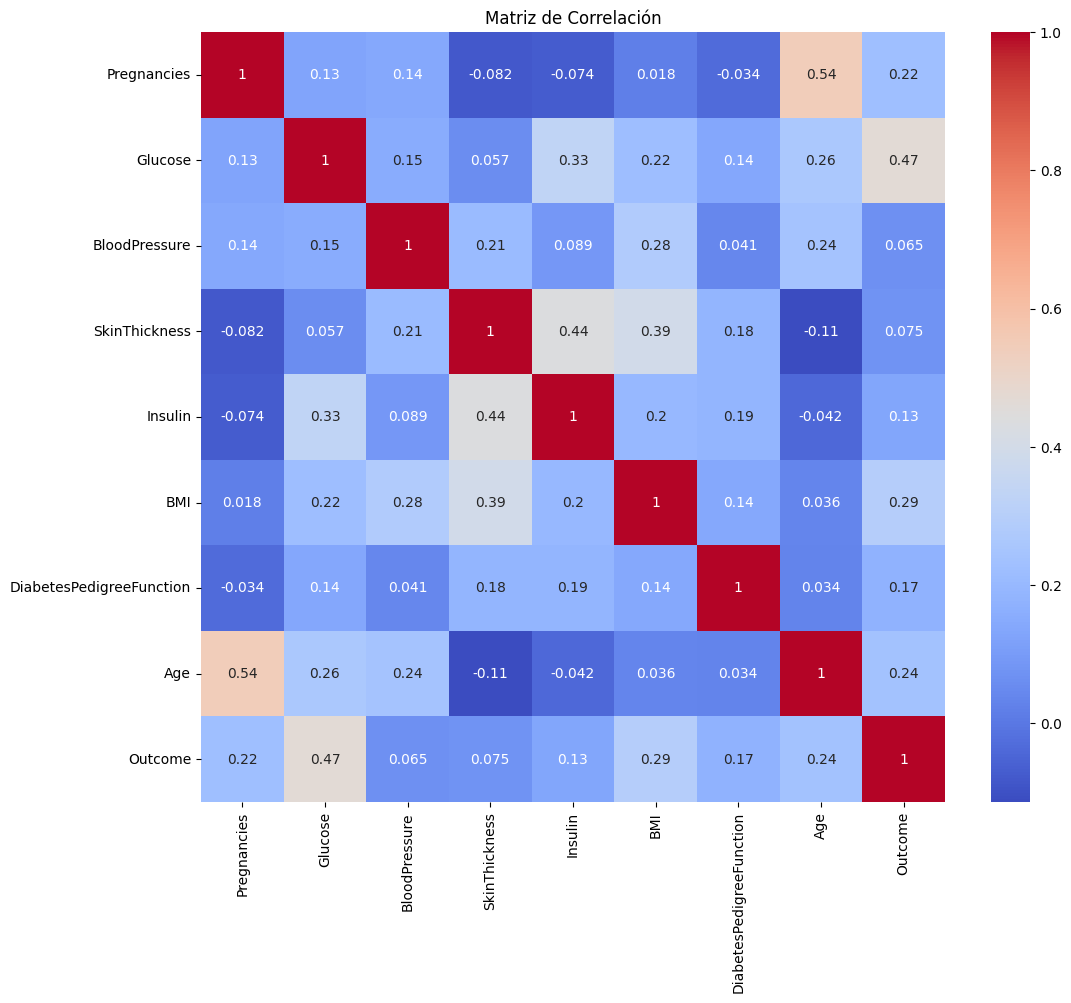

In [10]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

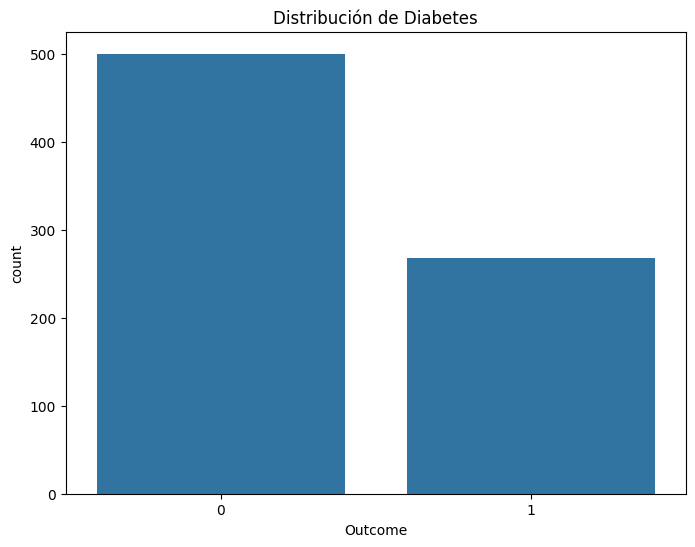

In [11]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribución de Diabetes')
plt.show()

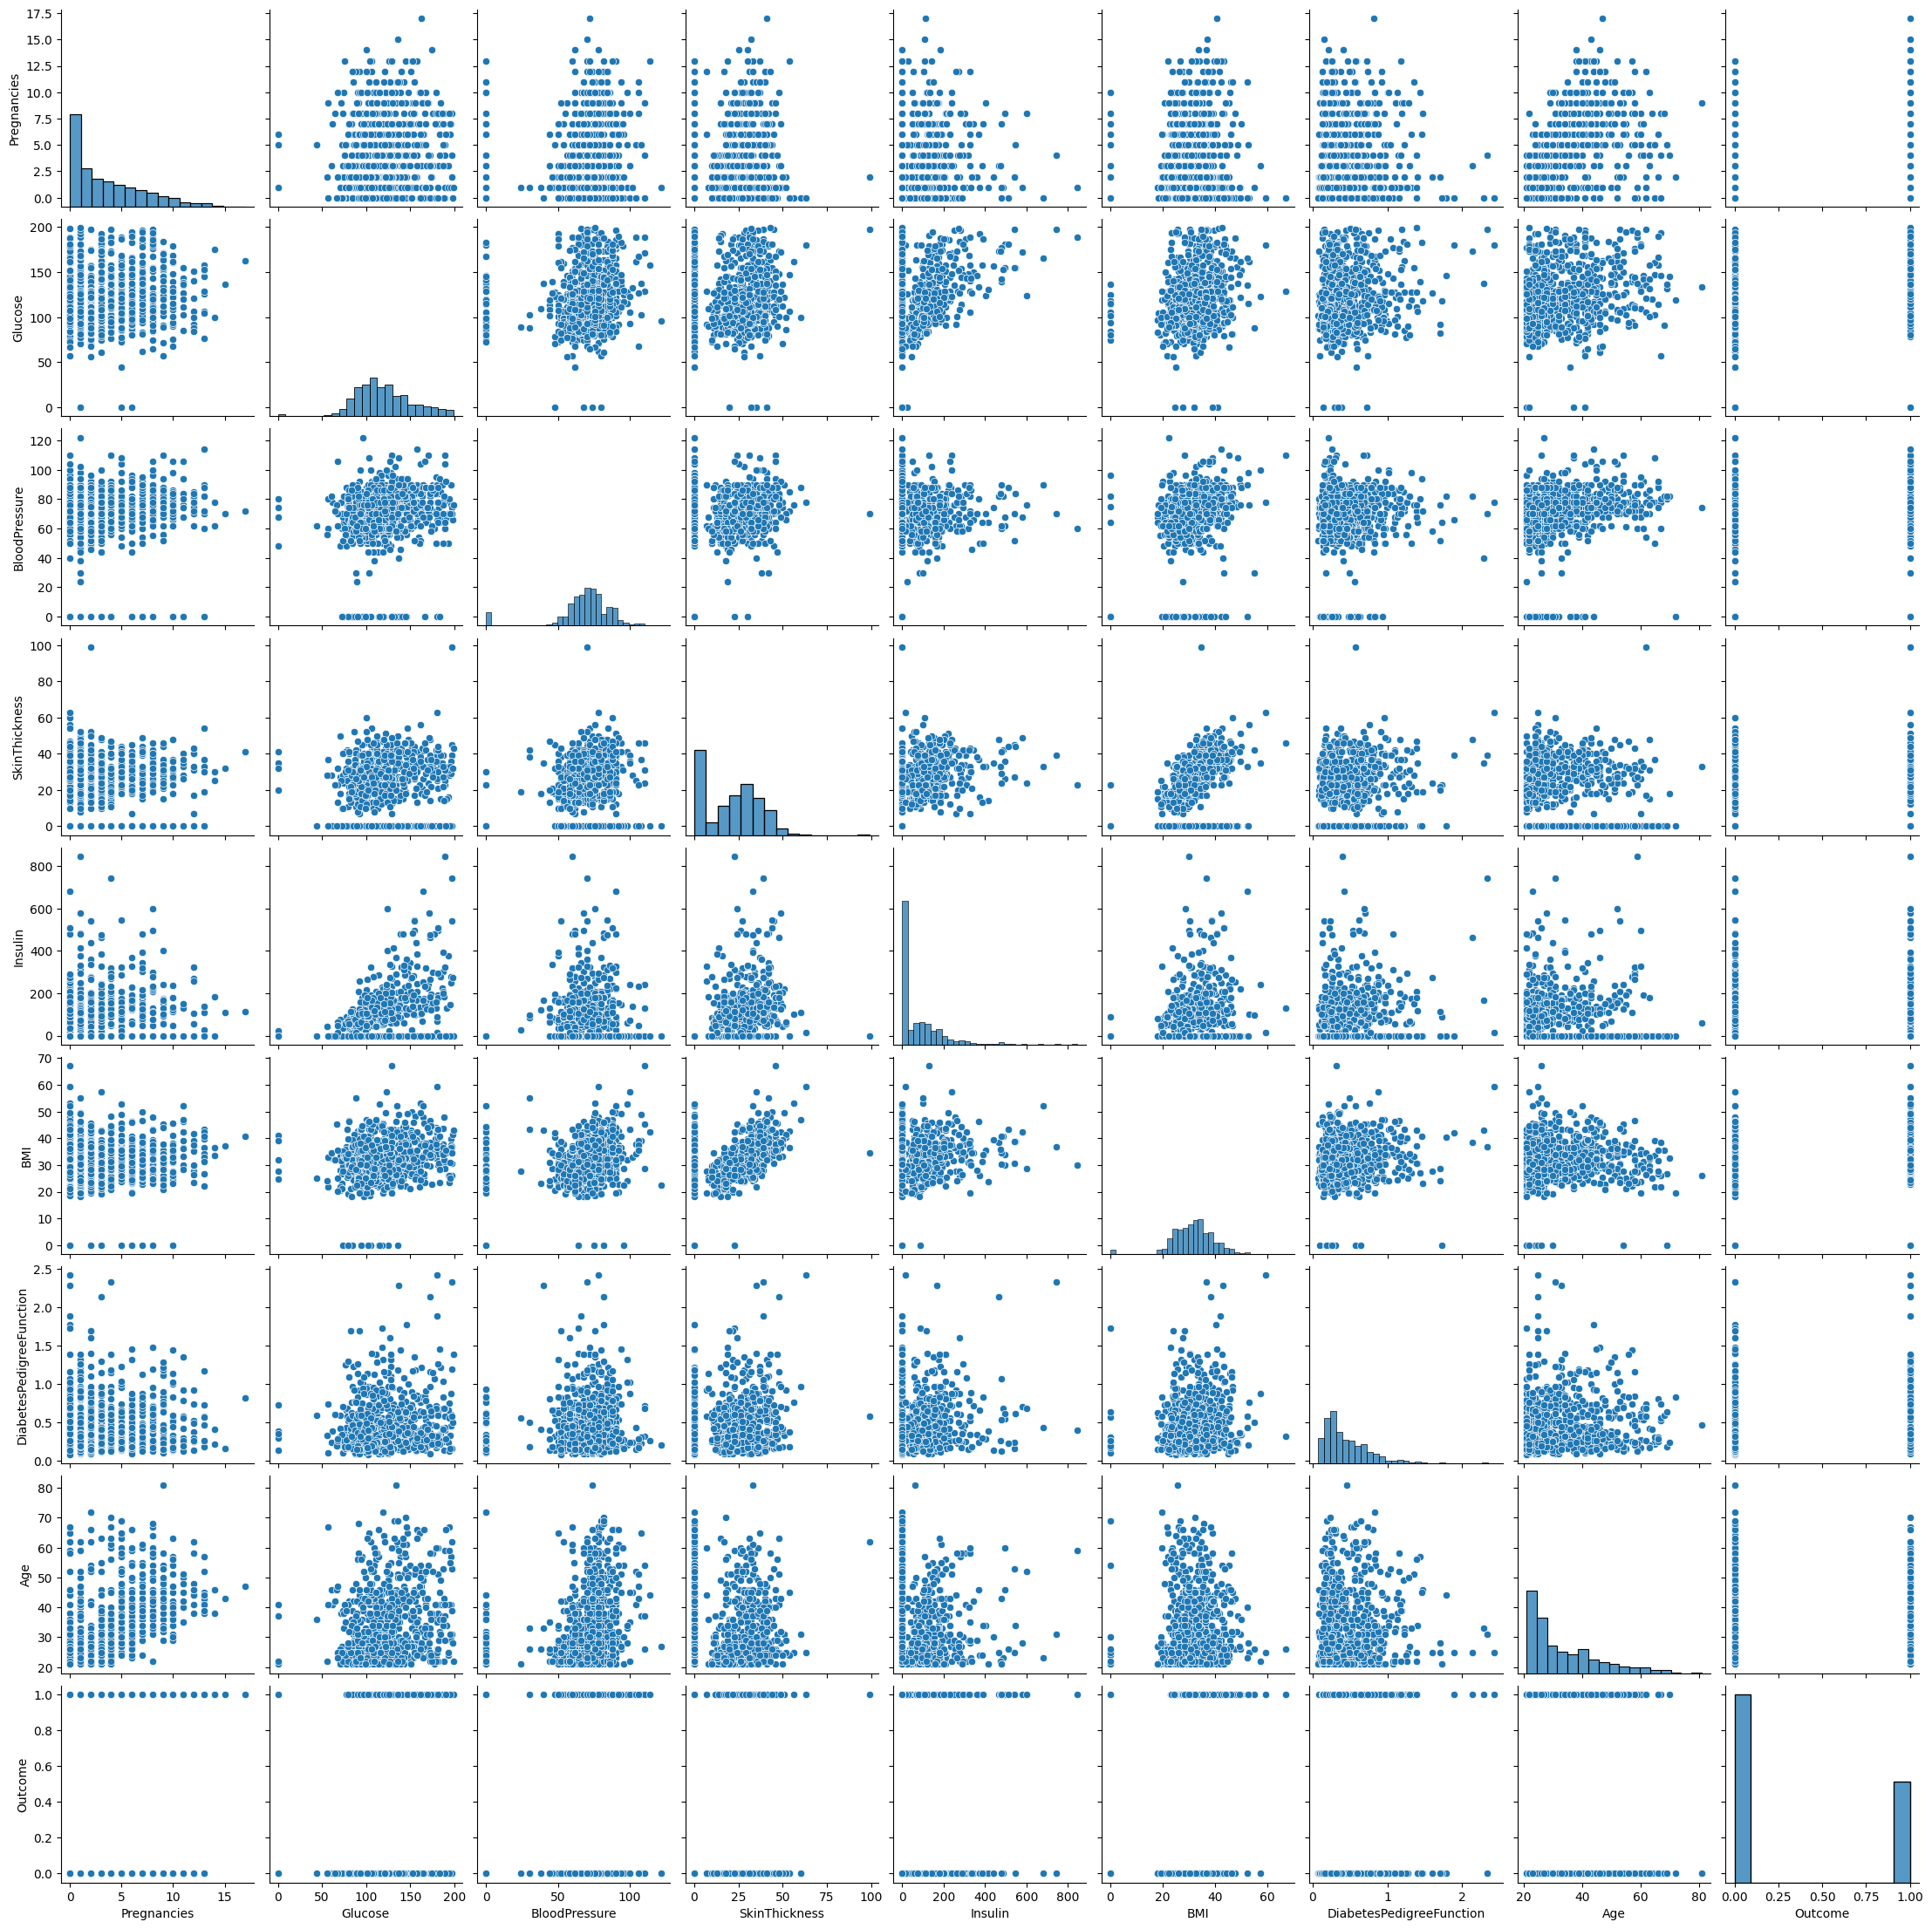

In [12]:
# Realizamos un pairplot
sns.pairplot(df)

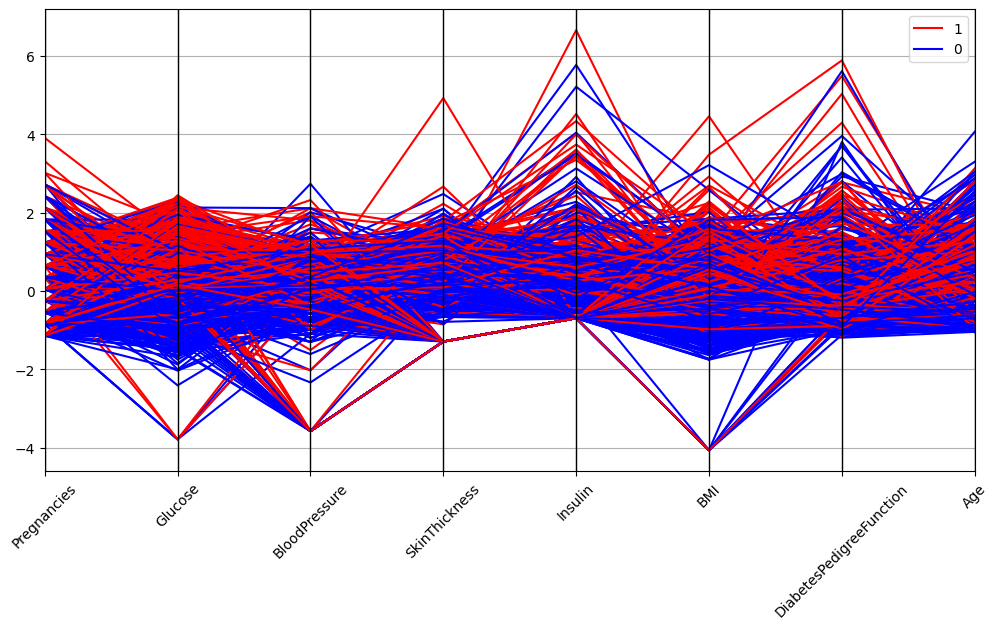

In [13]:
# Escalar las características del DataFrame, excluyendo la columna 'Outcome'
df_sc = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df.Outcome

# Creamos un gráfico de coordenadas paralelas para visualizar las características escaladas
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

# Datos de Entrenamiento y de Prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'],axis=1), df['Outcome'], test_size=0.2, random_state=42)

# Modelo de Árbol de Decisión

In [15]:
# Creamos el árbol de decisión
modelo_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42,)
modelo_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [16]:
# Crear un DataFrame con la importancia de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': modelo_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [17]:
# Visualizamos la importancia de las características
print(feature_importance)

                    Feature  Importance
1                   Glucose    0.305037
5                       BMI    0.155262
2             BloodPressure    0.135840
7                       Age    0.120047
6  DiabetesPedigreeFunction    0.114904
3             SkinThickness    0.075706
4                   Insulin    0.060706
0               Pregnancies    0.032499


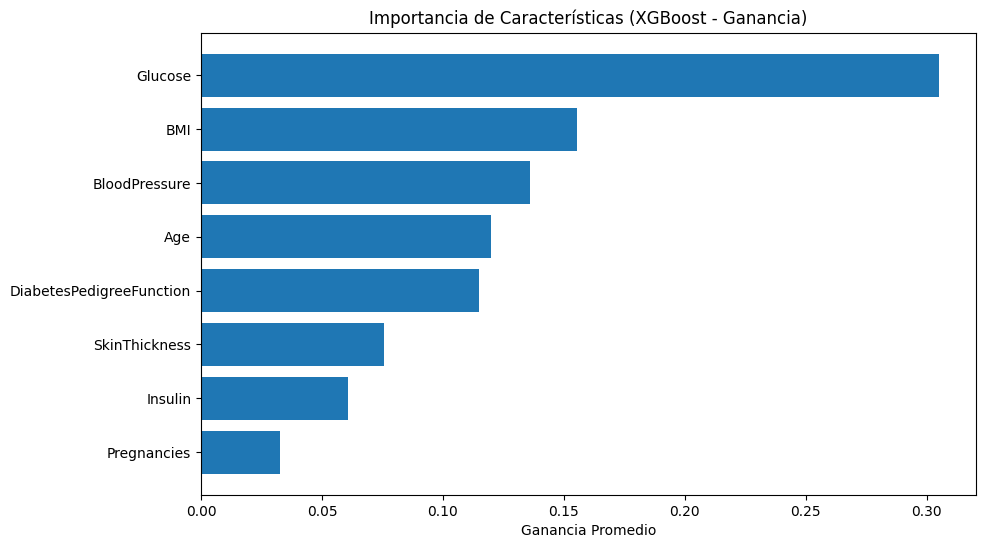

In [18]:
# Gràfica de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Importancia de Características (XGBoost - Ganancia)')
plt.xlabel('Ganancia Promedio')
plt.gca().invert_yaxis()  # Mostrar la característica más importante arriba
plt.show()

In [19]:
# Modelo con todas las variables
modelo_tree_all = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred_all = modelo_tree_all.predict(X_test)
print("Métricas con todas las variables:")
print(classification_report(y_test, y_pred_all))

# Modelo con variables seleccionadas
variables_seleccionadas = ['Glucose', 'BMI', 'BloodPressure', 'Age', 'DiabetesPedigreeFunction','SkinThickness', 'Insulin']
modelo_tree_selecto = DecisionTreeClassifier(random_state=42).fit(X_train[variables_seleccionadas], y_train)
y_pred_selected = modelo_tree_selecto.predict(X_test[variables_seleccionadas])
print("Métricas con variables seleccionadas:")
print(classification_report(y_test, y_pred_selected))

Métricas con todas las variables:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79        99
           1       0.62      0.73      0.67        55

    accuracy                           0.75       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.75      0.75       154

Métricas con variables seleccionadas:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79        99
           1       0.61      0.69      0.65        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.72       154
weighted avg       0.74      0.73      0.74       154



Con todas las variables: El modelo tiene una precisión y un recall más altos para ambas clases, lo que sugiere que el uso de todas las variables proporciona un mejor rendimiento general.
Con variables seleccionadas: Aunque el modelo sigue siendo razonablemente bueno, hay una ligera disminución en la precisión, el recall y el F1-score, especialmente para la clase 1

# Hiperparámetros

Como se empleará todos los datos se buscará los hiperparámetros del modelo

In [20]:
# hiperparámetros a probar
param_grid = {
    "max_depth": [10, 15, 20, 25, None],    # Profundidades diferentes
    "min_samples_leaf": [5, 10, 15, 20],    # Mínimo de muestras por hoja
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1],    # Poda del árbol
    "criterion": ["gini", "entropy"],       # Métrica de división
    "splitter": ["best", "random"],         # Estrategia de división
    "max_features": ["sqrt", "log2", None]  # Número de características consideradas
}

# Optimización con GridSearchCV
grid_search = GridSearchCV(
    modelo_tree, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [21]:
# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'ccp_alpha': 0.01, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 20, 'splitter': 'best'}


In [22]:
# El mejor modelo
best_model = grid_search.best_estimator_

In [23]:
# Aplicamos al árbol los datos de entrenamiento y de test

train_pred_simple = best_model.predict(X_train)
test_pred_simple = best_model.predict(X_test)

# Métricas de Evaluación

In [24]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [25]:
print(get_metrics(y_train, y_test, train_pred_simple, test_pred_simple))

            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.781759  0.736220  0.804304   0.633898  0.877934     0.730673
Test        0.694805  0.651852  0.718182   0.550000  0.800000     0.636364
Diferencia  0.086954  0.084369  0.086122   0.083898  0.077934     0.094310


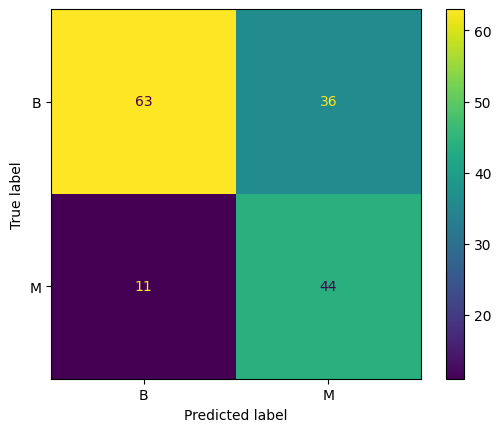

In [26]:
# Matriz de Confusión
cm = confusion_matrix(y_test, test_pred_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [27]:
# Evaluación en test
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Accuracy en el conjunto de prueba: 0.6948

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.64      0.73        99
           1       0.55      0.80      0.65        55

    accuracy                           0.69       154
   macro avg       0.70      0.72      0.69       154
weighted avg       0.74      0.69      0.70       154



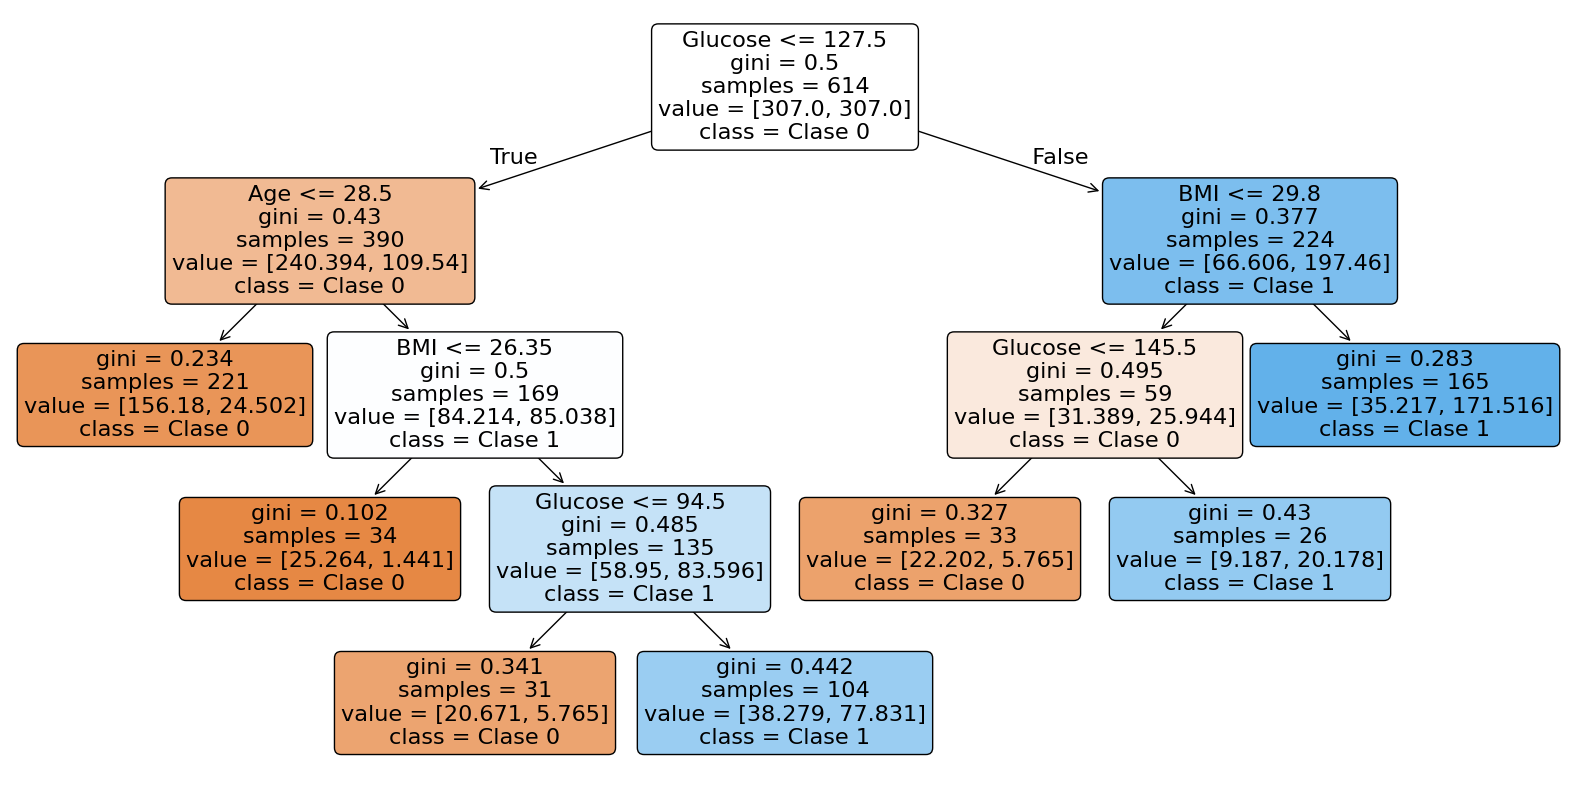

In [28]:
# Diagrama del Árbol de Decisión creado
plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['Clase 0', 'Clase 1'],  # Nombres de las clases
    filled=True,
    rounded=True,
    max_depth=5  # Limitar la profundidad para visualización
)
plt.show()

# Save los archivos

In [29]:
# Convertir los arrays numpy escalados a DataFrames de pandas
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# Añadir la columna 'y' a los DataFrames escalados
X_train["y"] = y_train.values
X_test["y"] = y_test.values

# Guardamos los archivos
X_train.to_csv("../data/processed/clean_train.csv", index = False)
X_test.to_csv("../data/processed/clean_test.csv", index = False)

In [30]:
# Guardamos el modelo
from pickle import dump

dump(best_model, open("../models/ArboldeDecision.sav", "wb"))

# Conclusiones

El modelo actual no es confiable para uso clínico directo debido a su baja especificidad y AUC moderado. Para implementarlo en producción, es crítico:

Priorizar métricas clínicas (Recall para diabéticos, Specificity para no diabéticos).

Validar con expertos médicos para contextualizar falsos positivos/negativos.